# Important Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score,fbeta_score
from imblearn.over_sampling import SMOTE

# Data Loading and Prepocessing

<span style="font-size:17px">The nan data is being replaced with the mean of that column, and marriage and education are being tuned to their range values</span>

In [7]:
df=pd.read_csv('train_dataset_final1.csv')

df=df.fillna(df.mean())

df['marriage'] = df['marriage'].apply(lambda x: x if x in [1,2,3] else df['marriage'].mode()[0])

df['education'] = df['education'].apply(lambda x: x if x in [1,2,3,4] else df['education'].mode()[0])

df.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio,next_month_default
0,5017,2,0,2,60000,25.0,2,2,2,0,...,20750.63,2000.21,0.00,1134.85,1821.78,1500.03,1500.24,41511.50,0.03,0
1,5018,2,1,1,290000,24.0,0,0,-2,-2,...,1350.30,0.00,0.17,0.00,2700.10,0.00,1349.72,2534.50,0.27,0
2,5019,1,0,2,180000,63.0,0,0,0,0,...,52991.51,2086.94,2199.99,1845.66,2000.35,1923.00,1999.78,50422.00,0.04,0
3,5020,1,1,2,210000,43.0,0,0,0,0,...,76945.47,3348.07,3380.91,3400.45,2683.97,2744.00,2892.10,86229.50,0.04,0
4,5021,2,0,1,280000,32.0,-2,-2,-2,-2,...,1.35,999.78,3186.27,45027.78,2100.09,0.01,0.27,11814.33,0.72,0


# Data Visualisation

### Target Variable: next_month_default

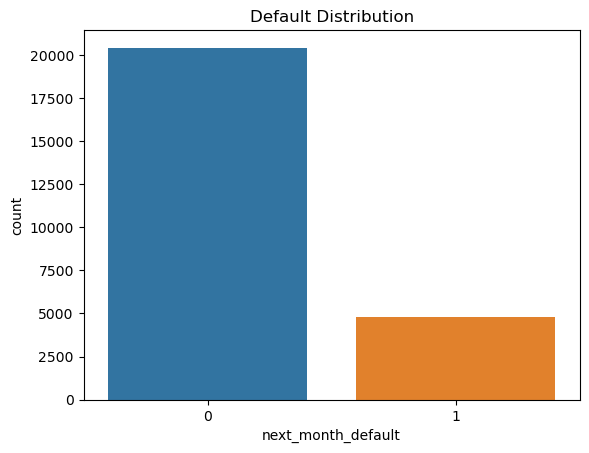

In [12]:
sns.countplot(x='next_month_default', data=df)

plt.title('Default Distribution')

plt.show()

<span style="font-size:17px">The above plot shows that the data is highly imbalanced. So we are using SMOTE to balance the dataset.</span>

### Categorical Variables: sex, marriage, education



### Numerical Variables: LIMIT_BAL, Age, AVG_Bill_amt, PAY_TO_BILL_ratio



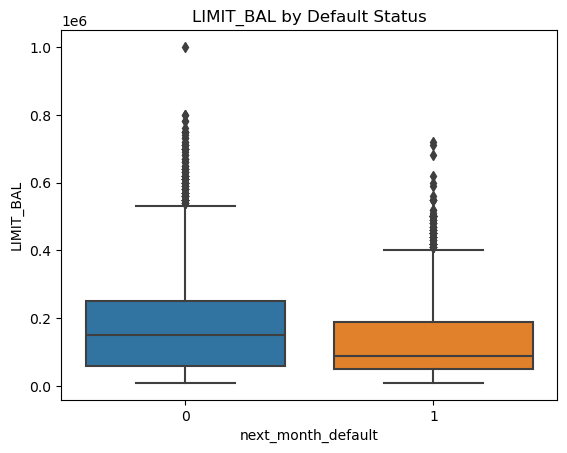

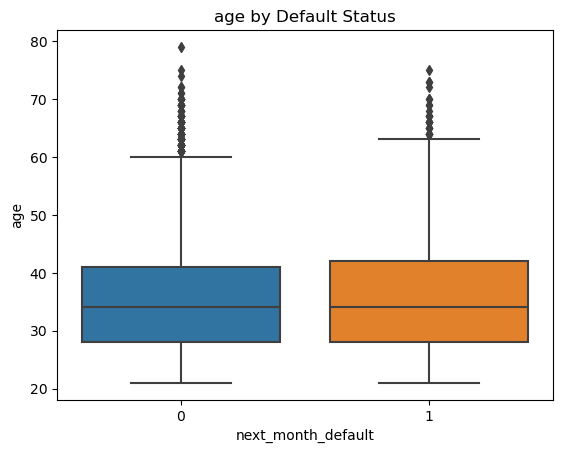

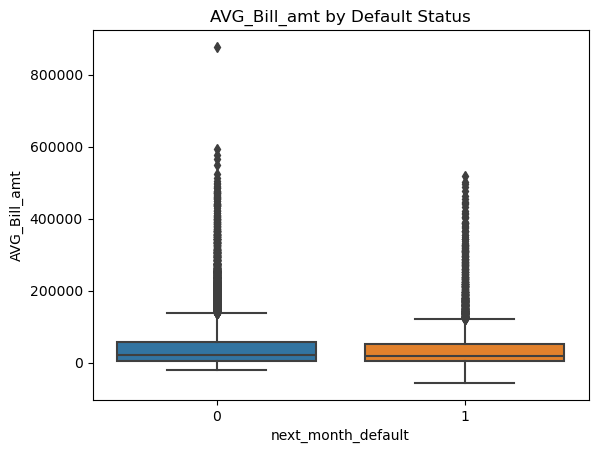

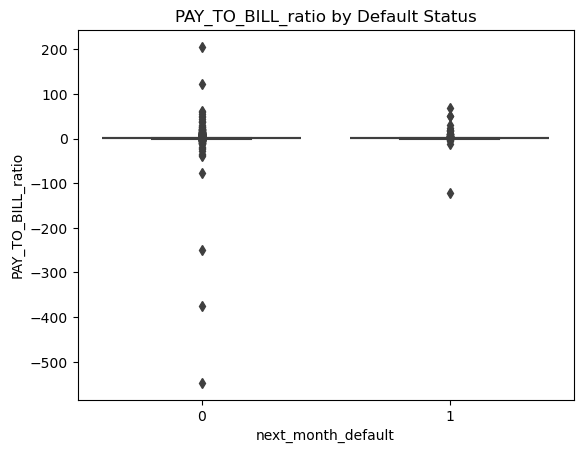

In [10]:
for col in ['LIMIT_BAL', 'age', 'AVG_Bill_amt', 'PAY_TO_BILL_ratio']:
    
    sns.boxplot(x='next_month_default', y=col, data=df)
    
    plt.title(f'{col} by Default Status')
    
    plt.show()


<span style="font-size:17px">The people with Low limit balance, low income and having low pay to bill ratio are 
defaulting more. Also people in the age group of 30-40 default more.</span>

### Repayment Status: Pay_0 to Pay_6



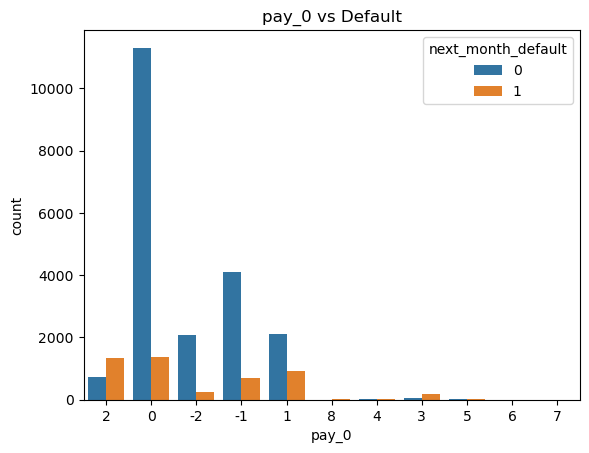

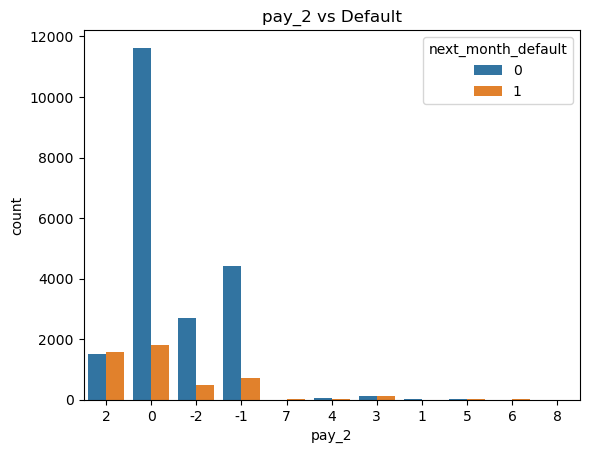

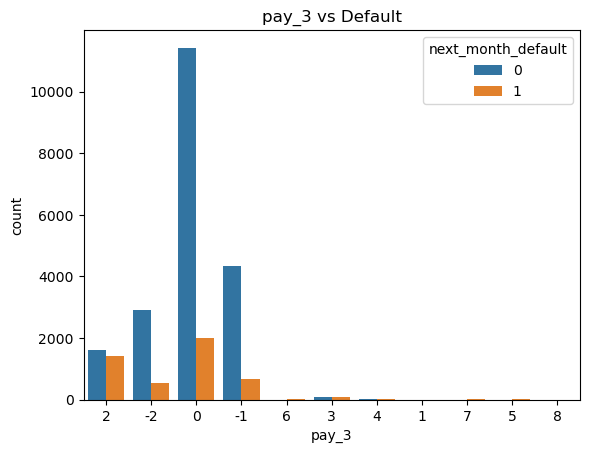

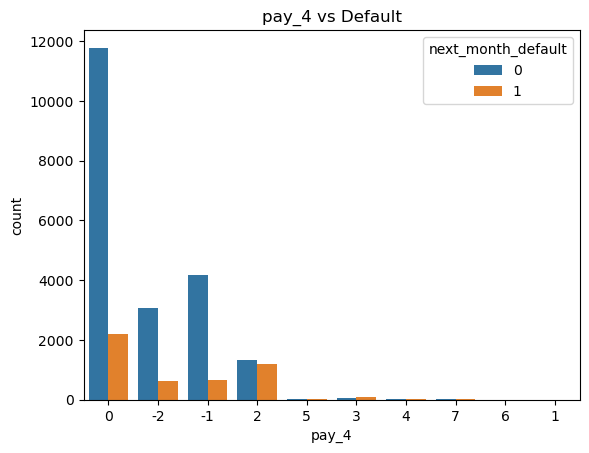

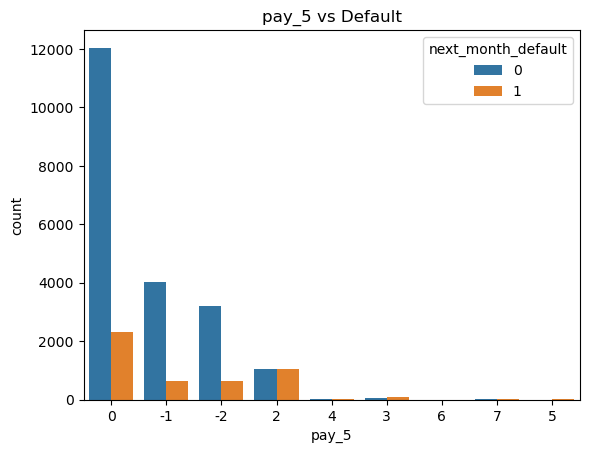

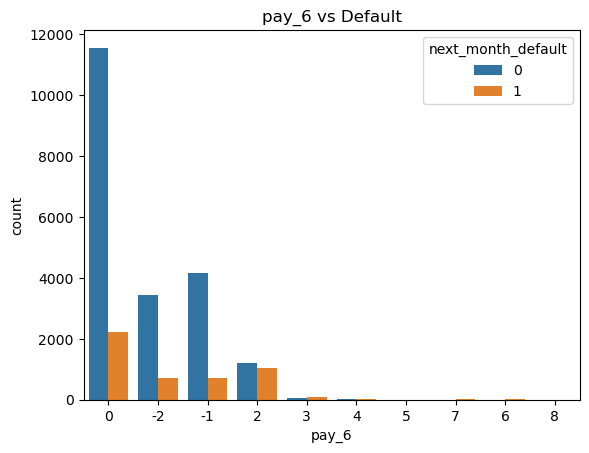

In [14]:
pay_cols = ['pay_0','pay_2','pay_3','pay_4','pay_5','pay_6']
df['next_month_default'] = df['next_month_default'].astype(str)

for col in pay_cols:
    df[col] = df[col].astype(str)  # Convert values to string

    sns.countplot(x=col, hue='next_month_default', data=df)
    plt.title(f'{col} vs Default')
    plt.show()



<span style="font-size:17px">The above plots show that the with the increasing delay in payment the defaulters increases.
</span>

### Correlation Matrix


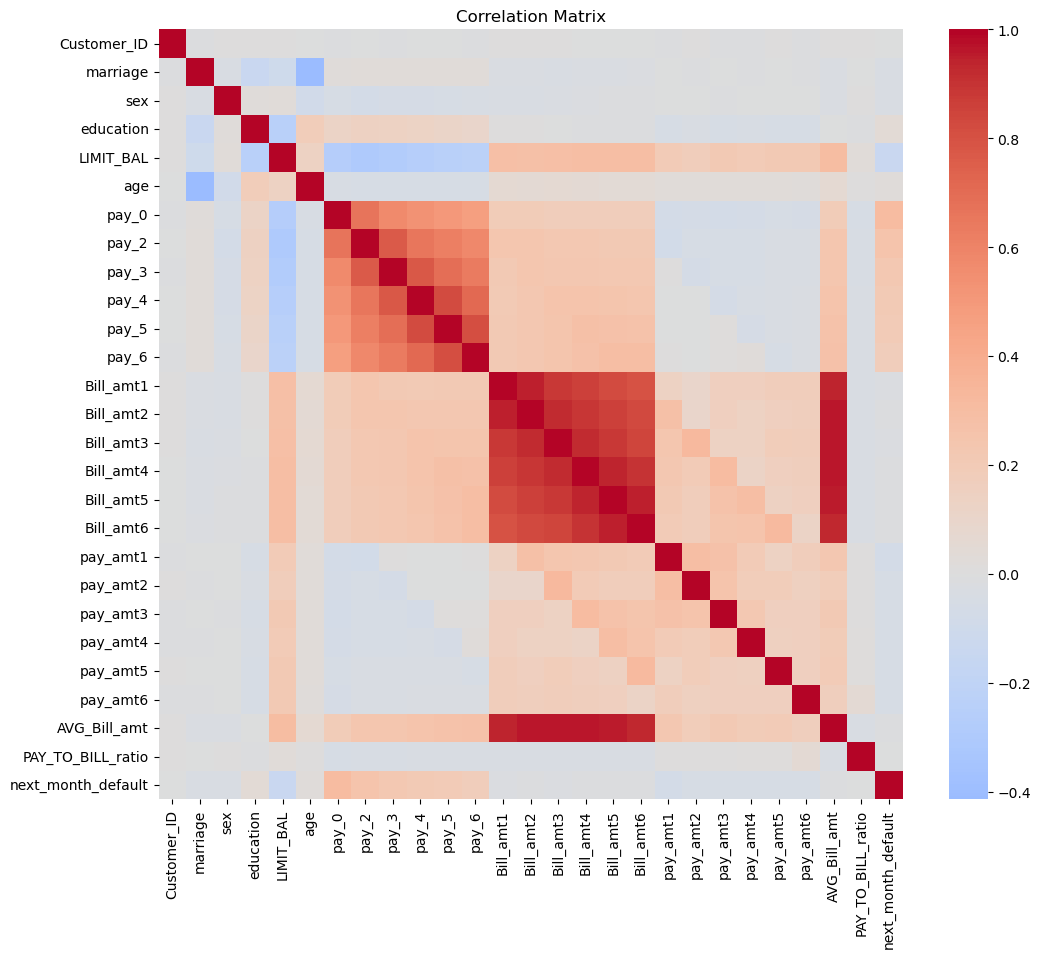

In [15]:
plt.figure(figsize=(12, 10))

sns.heatmap(df.corr(), cmap='coolwarm', center=0)

plt.title('Correlation Matrix')

plt.show()

<span style="font-size:17px">Pay_0 to Pay_6 has a good correlation with next_month_default. Also there is high correlaion between Bill_amt and Pay_amt</span>

# Preparing for modeling

<span style="font-size:17px">To balance the dataset, SMOTE is used, and the data is being split to 75:25 for training and testing the model</span>

In [16]:
x=df.drop(columns=['Customer_ID','next_month_default'])

y=df['next_month_default']

smote = SMOTE(sampling_strategy='minority', random_state=42)

x_train,x_test,y_train,y_test= train_test_split(x, y, test_size=0.25, random_state=42)

scaler = StandardScaler().fit(x_train)

x_scaled_train = scaler.transform(x_train)

x_scaled_test = scaler.transform(x_test)

x_new,y_new=smote.fit_resample(x_scaled_train,y_train)


## Model 1: Logistic Reasoning


In [17]:
model = LogisticRegression(max_iter=1000)

model.fit(x_new, y_new)

y_pred = model.predict(x_scaled_test)

y_proba = model.predict_proba(x_scaled_test)[:, 1]

print(classification_report(y_test, y_pred))

print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.67      0.77      5129
           1       0.32      0.67      0.43      1183

    accuracy                           0.67      6312
   macro avg       0.61      0.67      0.60      6312
weighted avg       0.79      0.67      0.71      6312

AUC-ROC: 0.7320937232750901



## Model 2:Decision Tree


In [18]:
model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_split=10,
    min_samples_leaf=5,
    criterion='entropy',
    random_state=42
)

model.fit(x_new,y_new)

y_pred = model.predict(x_scaled_test)

y_proba = model.predict_proba(x_scaled_test)[:, 1]

print(classification_report(y_test, y_pred))

print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.89      0.86      0.88      5129
           1       0.47      0.54      0.50      1183

    accuracy                           0.80      6312
   macro avg       0.68      0.70      0.69      6312
weighted avg       0.81      0.80      0.81      6312

AUC-ROC: 0.747290241441148



## Model 3: XGBoost Classifier


In [20]:
# Ensure y values are integers
y_new = y_new.astype(int)
y_test = y_test.astype(int)

# Fit model
model.fit(x_new, y_new)

# Predict
y_pred = model.predict(x_scaled_test)
y_proba = model.predict_proba(x_scaled_test)[:, 1]

# Evaluate
print(classification_report(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.89      0.85      0.87      5129
           1       0.45      0.55      0.50      1183

    accuracy                           0.79      6312
   macro avg       0.67      0.70      0.68      6312
weighted avg       0.81      0.79      0.80      6312

AUC-ROC: 0.7746071886330146



## Model 4: RandomForest Classifier


In [21]:
model = RandomForestClassifier(
    n_estimators=100,         
    max_depth=4,               
    min_samples_split=10,    
    min_samples_leaf=5,        
    criterion='entropy',     
    random_state=42
)

model.fit(x_new, y_new)

y_pred = model.predict(x_scaled_test)

y_proba = model.predict_proba(x_scaled_test)[:, 1]

print(classification_report(y_test, y_pred))

print("AUC-ROC:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87      5129
           1       0.46      0.57      0.51      1183

    accuracy                           0.79      6312
   macro avg       0.68      0.71      0.69      6312
weighted avg       0.81      0.79      0.80      6312

AUC-ROC: 0.7753272418599293


In [23]:
pay_cols = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

for col in pay_cols:
    # Convert to numeric, set errors='coerce' to turn invalid entries into NaN
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Optional: fill or drop NaNs after conversion
df.dropna(subset=pay_cols, inplace=True)  # drop rows with NaNs in pay_* columns
# OR, you could do: df[pay_cols] = df[pay_cols].fillna(0)



# Best Model Selection

### Summarising the results:

| Model               | F1-Score | Recall | Precision | AUC Score |
|---------------------|----------|--------|-----------|-----------|
| Logistic Regression | 0.43     | 0.67   | 0.32      | 0.732     |
| Decision Tree       | 0.50     | 0.54   | 0.47      | 0.747     |
| XGBClassifier       | 0.50     | 0.55   | 0.45      | 0.774     |
| LightGBM            | 0.48     | 0.56   | 0.42      | 0.695     |
| RandomForest        | 0.51     | 0.57   | 0.46      | 0.775     |

For bank defaulter detection, **high precision and recall** are important.  
- **F1-score** balances them, so we prefer the model with the highest F1-score.  
- **Recall** ensures more defaulters are caught.  
- **AUC score** reflects the model's ability to rank defaulters above non-defaulters.

Hence, **RandomForest Classifier**, with the best **AUC**, **F1-score**, and **recall**, is the best choice.




# Selection of Classification Threshold 

<span style="font-size:17px">Since bank priotizes more on recall than precision, so the best classification threshold is being found which gives the highest  F2-score</span>

Best Threshold for F2 Score: 0.41
Best F2 Score: 0.6


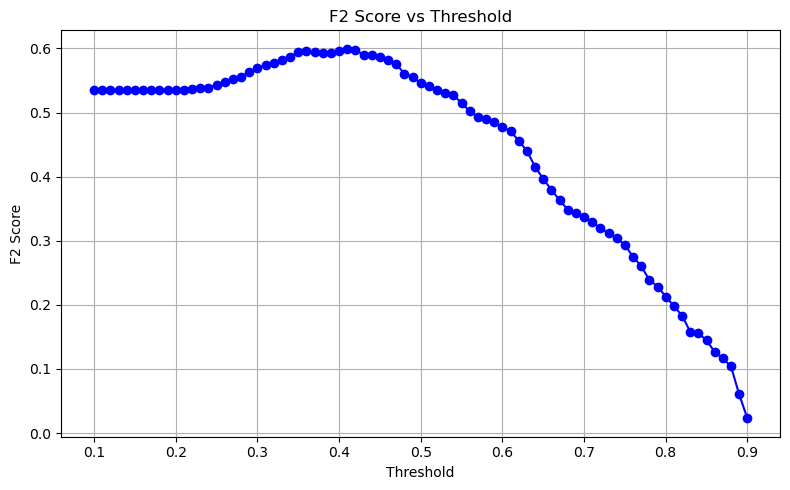

In [24]:
thresholds = np.arange(0.1, 0.91, 0.01)

best_threshold = 0
best_f2 = 0
f2_scores = []

for t in thresholds:
    y_pred_thresh = (y_proba >= t).astype(int)
    f2 = fbeta_score(y_test, y_pred_thresh, beta=2)
    f2_scores.append(f2)
    
    if f2 > best_f2:
        best_f2 = f2
        best_threshold = t

print("Best Threshold for F2 Score:", round(best_threshold, 2))
print("Best F2 Score:", round(best_f2, 2))

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f2_scores, marker='o', color='blue')
plt.xlabel('Threshold')
plt.ylabel('F2 Score')
plt.title('F2 Score vs Threshold')
plt.grid(True)
plt.tight_layout()
plt.show()


In [25]:
y_pred_new = (y_proba > 0.42).astype(int)

print(classification_report(y_test, y_pred_new))

print("AUC-ROC:", roc_auc_score(y_test, y_proba))

f2 = fbeta_score(y_test, y_pred_new, beta=2)

print("F2 Score:", f2)

              precision    recall  f1-score   support

           0       0.92      0.63      0.75      5129
           1       0.32      0.76      0.45      1183

    accuracy                           0.66      6312
   macro avg       0.62      0.70      0.60      6312
weighted avg       0.81      0.66      0.69      6312

AUC-ROC: 0.7753272418599293
F2 Score: 0.59781885889081



| F1-Score | Recall | Precision | AUC Score |
|----------|--------|-----------|-----------|
| 0.45     | 0.76   | 0.32      | 0.775     |
</span>

## Evaluation of Validation Dataset

In [26]:
df1=pd.read_csv("validate_dataset_final.csv")

df1=df1.fillna(df1.mean())

df1['marriage'] = df1['marriage'].apply(lambda x: x if x in [1,2,3] else df1['marriage'].mode()[0])

df1['education'] = df1['education'].apply(lambda x: x if x in [1,2,3,4] else df1['education'].mode()[0])

df1.head()

,Customer_ID,marriage,sex,education,LIMIT_BAL,age,pay_0,pay_2,pay_3,pay_4,...,Bill_amt5,Bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,AVG_Bill_amt,PAY_TO_BILL_ratio
0,1,1,1,2,220000,32,0,0,0,0,...,17831.13,15670.47,2000.03,3999.90,1419.80,1999.97,3000.21,30788.71,23456.33,0.31
1,2,2,0,1,350000,35,-1,-1,-1,0,...,10832.78,2261.45,33891.01,16267.19,4026.80,234.10,1565.11,26346.39,13660.33,1.00
2,3,2,1,1,310000,39,0,0,0,0,...,240520.57,246524.45,11026.94,10499.83,14000.32,10000.12,10000.16,10000.21,258034.17,0.04
3,4,1,0,2,20000,47,0,0,0,2,...,15040.17,14749.97,1200.00,2799.83,0.14,1499.93,0.02,1000.26,13333.33,0.08
4,5,2,1,2,500000,30,0,0,0,0,...,69054.15,64841.30,25463.94,43095.31,7521.96,9065.17,8841.07,12000.21,77204.50,0.23


In [27]:
xval=df1.drop(columns=['Customer_ID'])

x_scaledval = scaler.transform(xval)

y_prob = model.predict_proba(x_scaledval)[:, 1]

threshold = 0.42

y_pred = (y_prob >= threshold).astype(int)

In [28]:
df_result = pd.DataFrame({
    'Customer_ID': df1['Customer_ID'],
    'Predicted_Default': y_pred
})

df_result.to_csv('predictions.csv', index=False)

In [29]:
print(pd.Series(y_pred).value_counts())

0    3751
1    1265
Name: count, dtype: int64
